# Machine Learning Tutorial 

## Modelling PV generation using weather data


Author: Max Bird - mhb316@ic.ac.uk

# Introduction

This notebook aims to cover a basic introduction to the applications of machine learning (ML) to real-world problems. Here we will use [supervised machine learning](https://towardsdatascience.com/a-brief-introduction-to-supervised-learning-54a3e3932590) methods to solve a regression problem: modelling the hourly generation for a photovoltaic (PV) installation using relevant weather data. Five years of historical generation data from a PV site in the UK and data from a nearby weather station are used as the dataset for this study. 


First let's list the major stages of any ML investigation:

1. Data cleaning
2. Preliminary Machine Learning Testing
3. Feature Selection
4. Hyperparameter Optimisation


We will walk through each stage in turn with example code and explanations, and at the end there will be questions to work through on your own. This tutorial is carried out in Python, using DataFrames for data handling and the [SKlearn](https://scikit-learn.org/stable/index.html) library for machine learning functionality. If you are unfamiliar with handling data in Python using pandas, spend 15 minutes or so looking over [this](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html).


First we need to install the SKlearn library:

In [1]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\max\anaconda3\envs\machinelearning\lib\site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


# Data Cleaning

ML models are generally entirely data-driven, and as most real-world data is usually messy and incomplete, it is vital to spend time looking at and cleaning raw data before starting any modelling work. 

First let's visualise the PV generation data:

             Timestamp  PV Generation (kWh)
15 2013-01-01 08:00:00              0.00000
16 2013-01-01 08:30:00              0.00000
17 2013-01-01 09:00:00              0.71468
18 2013-01-01 09:30:00              3.44150
19 2013-01-01 10:00:00              7.03160
20 2013-01-01 10:30:00             10.52400
21 2013-01-01 11:00:00             13.22300
22 2013-01-01 11:30:00             12.96800
23 2013-01-01 12:00:00             13.50100
24 2013-01-01 12:30:00             13.75800
25 2013-01-01 13:00:00             11.30000
26 2013-01-01 13:30:00              8.36770
27 2013-01-01 14:00:00              6.64640
28 2013-01-01 14:30:00              3.27340
29 2013-01-01 15:00:00              3.09480
30 2013-01-01 15:30:00              0.74352
31 2013-01-01 16:00:00              0.00920
32 2013-01-01 16:30:00              0.00000
33 2013-01-01 17:00:00              0.00000


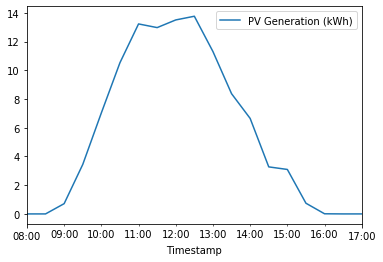

In [2]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt

# load in PV generation and weather data
pv_data = pd.read_excel("PV_and_weather_data.xlsx", sheet_name = "PV Generation") 

# take an example day to look at
day1_pv = pv_data.iloc[15:34, :]
print(day1_pv)

# plot line graph of day1 generation
day1_pv.plot(x = "Timestamp", y="PV Generation (kWh)")



We can see we have half-hourly PV generation in kWh with the associated timestamp given for the end of the observation period. Now let's look at the different weather variables we have:


             Timestamp  Irradiance (kJ/m2)  Solar Azimuth (°)  \
7  2013-01-01 08:00:00                 0.0          66.764189   
8  2013-01-01 09:00:00                27.0          55.550041   
9  2013-01-01 10:00:00               279.0          43.713045   
10 2013-01-01 11:00:00               537.0          31.026435   
11 2013-01-01 12:00:00               781.0          17.476836   
12 2013-01-01 13:00:00               926.0           3.318159   
13 2013-01-01 14:00:00               761.0         -10.968842   
14 2013-01-01 15:00:00               420.0         -24.851469   
15 2013-01-01 16:00:00               104.0         -37.956410   
16 2013-01-01 17:00:00                 1.0         -50.175768   

    Solar Altitude (°)  Wind Direction (°)  Wind Speed (knots)  \
7           -11.002359               250.0                 9.0   
8            -2.834427               250.0                 8.0   
9             4.451614               250.0                 8.0   
10           10.0288

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CE55239CC8>,
      dtype=object)

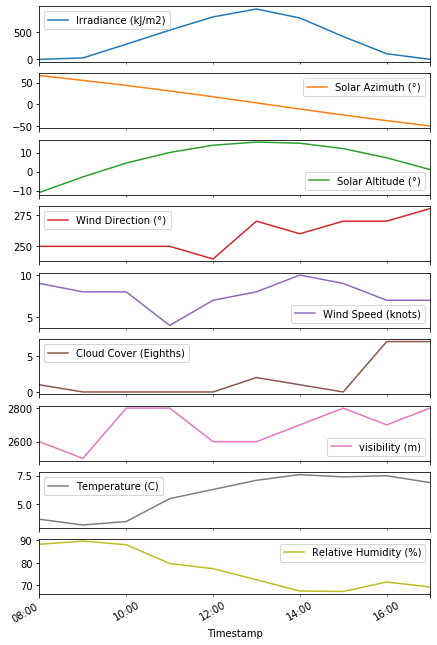

In [3]:
# load in weather data
weather_data = pd.read_excel("PV_and_weather_data.xlsx", sheet_name = "Weather Data")

day1_weather = weather_data.iloc[7:17, :] # select rows 7-17, and all (:) columns
print(day1_weather)
day1_weather.plot(x = "Timestamp", y=[1,2,3,4,5,6,7,8,9], subplots=True, figsize=(7,12))

We can see we have 9 different weather variables at hourly granularity: irradiance, solar azimuth and altitude, wind speed and direction, cloud cover, visibility, ambient temperature and relative humidity.


Now that we have a rough idea of what the data looks like, we should begin the processing stage. First let's look at how many empty entries there are for the PV and weather data. This can be accomplished using the isna() function in pandas:

In [4]:
missing_pv = pv_data.isna().sum() # this will produce a new dataframe with the number of empty entries in pv_data
print(missing_pv)
print("")

# calculate % completeness of PV data
percent_complete = ((len(pv_data) - missing_pv['PV Generation (kWh)'])/len(pv_data))*100
print('PV Generation completeness: %.2f' % (percent_complete) + "%") # print the % completness to 2 decimal places
    

Timestamp              0
PV Generation (kWh)    7
dtype: int64

PV Generation completeness: 99.99%


In this case we are lucky! The dataset is very complete, with only 7 missing entries across the entire 5 year period. Now let's do the same for the weather data:

In [5]:
missing_weather = weather_data.isna().sum()
print(missing_weather)
print("")

# this time we need a for loop to calculate the % completness of each weather type individually
for col in list(weather_data.columns): 
    percent_complete = ((len(weather_data) - missing_weather[col])/len(weather_data))*100
    print(col + ' completeness: %.2f' % (percent_complete) + "%")

Timestamp                  0
Irradiance (kJ/m2)       318
Solar Azimuth (°)          0
Solar Altitude (°)         0
Wind Direction (°)       204
Wind Speed (knots)       204
Cloud Cover (Eighths)    330
visibility (m)           181
Temperature (C)          185
Relative Humidity (%)    202
dtype: int64

Timestamp completeness: 100.00%
Irradiance (kJ/m2) completeness: 99.27%
Solar Azimuth (°) completeness: 100.00%
Solar Altitude (°) completeness: 100.00%
Wind Direction (°) completeness: 99.53%
Wind Speed (knots) completeness: 99.53%
Cloud Cover (Eighths) completeness: 99.25%
visibility (m) completeness: 99.59%
Temperature (C) completeness: 99.58%
Relative Humidity (%) completeness: 99.54%


We can see the weather has a few more missing entries than the PV data, but still has over 99% for each datatype. In this case, where the number of missing entries is very small, we can simply remove all observations which are missing one or more of a variable. This will ensure our machine learning model will have a complete set of observations for each timestamp used. 

To make this process easier, we first need to combine the PV and weather dataframes into one master dataframe. As the weather data is only avaliable at hourly resolution, we need to downsample the PV generation from half-hourly to hourly readings, to ensure they match up correctly. As the generation is recorded in kWh this is as simple as adding the XX:30 and XX:00 readings, which can be handled directly in pandas using the resample function. As before, the timestamp will represent the end of the hour, e.g. the 09:00 generation reading is the generation recorded between 08:00 - 09:00.

In [6]:
pv_data = pv_data.resample('H', on='Timestamp', closed ='right', label='right').sum().reset_index()
print(pv_data.iloc[7:17, :])

             Timestamp  PV Generation (kWh)
7  2013-01-01 08:00:00              0.00000
8  2013-01-01 09:00:00              0.71468
9  2013-01-01 10:00:00             10.47310
10 2013-01-01 11:00:00             23.74700
11 2013-01-01 12:00:00             26.46900
12 2013-01-01 13:00:00             25.05800
13 2013-01-01 14:00:00             15.01410
14 2013-01-01 15:00:00              6.36820
15 2013-01-01 16:00:00              0.75272
16 2013-01-01 17:00:00              0.00000



Now we can combine the PV and weather data into one dataframe, and remove all rows with any NaN (empty) entries. We can also remove all rows where the recorded PV generation is 0 (nighttime readings) as we want our ML model to only learn the daytime behaviour of the PV systems. Finally we can also remove the timestamps themselves as a feature, as the ML models we will use treat each datapoint as IID (independent and identically distributed) and so the time will not be useful.

In [7]:
# combine both data sets into one
all_data = pd.concat([pv_data, weather_data.iloc[:, 1:]], axis=1)

# remove all rows with any NaN entries
all_data = all_data.dropna()

# remove rows where PV generation is zero using masking
mask = all_data['PV Generation (kWh)'] != 0
all_data = all_data[mask]

# remove timestamps
all_data = all_data.drop(labels='Timestamp', axis=1)


# check all NaN values have been removed, using method from earlier
missing_data = all_data.isna().sum()
print(missing_data) # table counting nan values for each datatype

# check percentage of rows removed 
percent_removed = ((len(pv_data) - len(all_data))/len(pv_data))*100
print("")
print("Percentage of observations removed: %.2f" % (percent_removed) + "%")

# check number of useable datapoints left
print("Rows remaining: %i" % (len(all_data)))

PV Generation (kWh)      0
Irradiance (kJ/m2)       0
Solar Azimuth (°)        0
Solar Altitude (°)       0
Wind Direction (°)       0
Wind Speed (knots)       0
Cloud Cover (Eighths)    0
visibility (m)           0
Temperature (C)          0
Relative Humidity (%)    0
dtype: int64

Percentage of observations removed: 50.25%
Rows remaining: 21803


Success! We now have a single clean dataset of over 20,000 hourly observations which we can use in our analysis. 






# Preliminary ML Investigation

Now that we have a clean and usable dataset, we can have a first pass at training and testing an ML model. This can be seen as a proof of concept step, to try and see if the problem we are trying to solve is even feasible. Let's start with an overview of the training and testing process. 

From our dataset we take 80% of the observations to use as a training set. During training stage we show the ML model the target data value (PV generation), and then we give it all the features (weather data) we think are related to the target. The ML model then uses this dataset to calculate the weighting and importance of each feature. Then, once the model is trained, we input the remaining 20% of observations in the testing stage, not including the target values, and it will give us predictions of what it thinks the target values are. By comparing these predictions with the actual target values we can evaluate the accuracy of the model.

One important thing to note before we start training our model is that it is incredibly important to scale or standardise our features to give each a mean of 0 and a standard deviation of 1. This will prevent the ML model from unfairly weighting those features which have larger absolute values. The target values generally do not need to be standardised. 

The below code shows the training and testing stage, followed by evaluating the model accuracy via some performance metrics.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import numpy as np

# separate the features and target data
features = all_data.iloc[:, 1:] # select all rows (observations) and columns (features) 1-end
target = all_data.iloc[:, 0]

# scale the data to give each feature a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
features = scaler.fit_transform(features)

# randomly split the observations into 80% training, 20% testing
training_features, testing_features, training_target, actual = train_test_split(features, target, 
                                                                                       test_size=0.2, random_state=0)

# initialise and train a basic Artifical Neural Network (ANN) with 9 nodes
clf = MLPRegressor(hidden_layer_sizes=(9,), random_state=0)
clf.fit(training_features, training_target)

# feed testing features to the trained model to get ML predictions
predicted = clf.predict(testing_features)

# calcualte R2 and mean relative error (MRE) between predictions and actual PV generation
R = r2_score(actual, predicted)

ave_actual = np.average(actual) 
mre = ((np.sum(abs((actual-predicted)/ave_actual)))/len(actual))*100

print("R2: %.2f" % (R))
print("MRE: %.1f" % (mre) + "%")

R2: 0.91
MRE: 20.2%


C:\Users\Max\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


We can see the model is already working well, reaching an R2 of 0.91 and MRE of 20.2%. Now we have determined the problem is feasible we can move on to improving the model through feature selection and hyperparameter optimisation.

Note: Ignore the convergence warning, this will be fixed during hyperparameter optimisation.



# Feature Selection

The next important step is to determine which features are most relevant to the target, which for us is hourly PV generation. By removing features, we help the model generalise better to new unseen data and reduce the risk of overfitting, while also decreasing the time taken for model training and testing. 

There are many different [feature selection techniques](https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e), but these are difficult to show and explain concisely in short-form tutorial, so instead I will cover a straight-forward but effective method: trial and error. We simply try training the model on different subsets of features and see the effect on the performance metrics. Ideally we want to identify the smallest subset of features which can give us the best modelling performance for the desired application. First let's try the most basic case using only irradiance. 

Note here we don't need to standardise the irradiance as it is the only feature.


In [9]:
features = all_data[['Irradiance (kJ/m2)']]
target = all_data.iloc[:,0]

training_features, testing_features, training_target, actual = train_test_split(features, target, 
                                                                                       test_size=0.2, random_state=0)
clf = MLPRegressor(hidden_layer_sizes=(10,), random_state=0)
clf.fit(training_features, training_target)
predicted = clf.predict(testing_features)

R = r2_score(actual, predicted)
ave_actual = np.average(actual) 
mre = ((np.sum(abs((actual-predicted)/ave_actual)))/len(actual))*100

print("R2: %.2f" % (R))
print("MRE: %.1f" % (mre) + "%")

R2: 0.82
MRE: 28.9%


The performance metrics have dropped noticably so clearly we need to include more than just irradiance. For an unknown problem this process would continue, making educated guesses of which features will be most important, retraining and retesting the model and calculating the performance metrics. In the interest of time I am going to fast forward to the best set of features I found: irradiance, solar position, temperature and relative humidity. 

In [10]:
features = all_data.iloc[:,[1,2,3,8,9]]
target = all_data.iloc[:,0]

scaler = StandardScaler()
features = scaler.fit_transform(features)

training_features, testing_features, training_target, actual = train_test_split(features, target, 
                                                                                       test_size=0.2, random_state=0)

clf = MLPRegressor(hidden_layer_sizes=(10,), random_state=0)
clf.fit(training_features, training_target)
predicted = clf.predict(testing_features)

R = r2_score(actual, predicted)
ave_actual = np.average(actual) 
mre = ((np.sum(abs((actual-predicted)/ave_actual)))/len(actual))*100

print("R2: %.2f" % (R))
print("MRE: %.1f" % (mre) + "%")

R2: 0.89
MRE: 22.0%


C:\Users\Max\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


We have managed to reduce the number of features from 9 to 5 while maintaining a very similar level of modelling accuracy. This will allow our model to generalise better for use on other PV installations and reduce the computational cost of running the model. These trade-offs are always present in ML and it is up to the user to decide which is best for the specific application.




# Hyperparameter Optimisation

[Hyperparameter optimisation](https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d) is the process of the user selecting different parameters of each ML model to get the best modelling accuracy for their specific application. Note that **hyperparameters** are not the same as the **model parameters**, which are calculated internally by the model during the training stage. For example a hyperparameter could be the number of nodes used in an Artificial Neural Network, while a model parameter would be the weighting of the irradiance feature. This hyperparameter optimisation is widely considered to be one of the most difficult steps in a machine learning workflow for a couple of reasons:


- The effect of each hyperparameter can be strongly dependent on the other hyperparameters, resulting in a large set of potential hyperparameter combinations  
- It can be difficult to understand the meaning/effect of some hyperparameters on modelling performance without an incredibly in-depth understanding of the model's underpinning mathematics


One effective method to address both these points is to use an exhaustive grid search algorithm to select the best combination of hyperparameters. Essentially the user will provide a range of potential values for each hyperparameter of interest, and the grid search will train and test the model for every possible combination of hyperparameters. For each combination it will save the value of a performance metric (usually R2), and then select the combination with the greatest modelling accuracy. This can be set up by hand, but here we will use the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) function from the sklearn library. We will apply the grid search to the basic ANN used in the previous stages, documentation for which can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html).


Due to the computational cost of the grid search, we will only include a couple of different hyperparameters in this example, namely the ANN's neural structure and the solver it uses to calculate model parameters. For a real problem you would include more hyperparameters and search over a larger range for each. 

In [11]:
from sklearn.model_selection import GridSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify and standardise data
features = all_data.iloc[:,[1,2,3,8,9]]
target = all_data.iloc[:,0]
scaler = StandardScaler()
features = scaler.fit_transform(features)
          
# hyperparameters to search over
params = {"solver": ['adam','sgd'],
         "hidden_layer_sizes": [(10,), (100,), (200,), (500,)]}

# initialise ML model you want to optimise
clf = MLPRegressor(random_state=0, max_iter=500)

# initialise and start the grid search
print('Beginning optimisation')
grid_search = GridSearchCV(clf, params, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(features, target)

# print the best 3 combinations 
report(grid_search.cv_results_)
print()

Beginning optimisation


KeyboardInterrupt: 

Here we can see the top three combinations have identical R2 values of 0.900, and so we will pick the one with the smallest network, as this will train and make predictions faster. Therefore our final model will use the 'sgd' solver and have one hidden layer of 200 neurons. Let's just run this best case model once more to calculate the other performance metrics:

In [ ]:
clf = MLPRegressor(hidden_layer_sizes = (200,), solver='sgd', random_state=0, max_iter=500)
clf.fit(training_features, training_target)
predicted = clf.predict(testing_features)

R = r2_score(actual, predicted)
ave_actual = np.average(actual) 
mre = ((np.sum(abs((actual-predicted)/ave_actual)))/len(actual))*100

print("R2: %.2f" % (R))
print("MRE: %.1f" % (mre) + "%")

Through this process we have managed to increase the R2 from 0.89 to 0.91 and reduced the MRE from 22.0% down to 19.4%. Although these improvements are modest, they are still noticable, and would be greater still if you had time to optimise over a larger set of hyperparameters. 

Now that we have our best model, let's plot the model's predictions against the actual generation to see how well we did. Note that we have removed the nighttime values so the plots will look slightly odd. 

In [ ]:
features = all_data.iloc[:,[1,2,3,8,9]]
target = all_data.iloc[:,0]
scaler = StandardScaler()
features = scaler.fit_transform(features)

# make predictions using previously trained model
week = 25
predicted = clf.predict(features[week*12*7:(week+1)*12*7])
actual = target[week*12*7:(week+1)*12*7]

example_week = pd.DataFrame(data={'Hour': range(len(predicted)),
                                 'Actual (kWh)': actual,
                                 'Predicted (kWh)': predicted})

example_week.plot(x = "Hour", y=[1,2], figsize=(10,3))


We have designed a complete ANN that can accurately model hourly PV generation based on weather data!

# Improvements

The purpose of this tutorial is to give those unfamiliar with machine learning an idea of the general workflow and major steps needed. To keep this tutorial digestable I have not gone into as much detail as I would have liked in some sections, so here are a few general points for improvement if you had more time:




1. More steps could be taken to clean and asses the quality of the raw data. For example, filtering out data points that are many standard deviations away from the mean. Data preprocessing is **the** most important step in any ML problem, and should take up the  majority of time spent on the problem. 


2. Ideally the feature selection and hyperparameter optimisation should be coupled together before choosing the best set of features/hyperparameters. This means identifying multiple possible combinations of features and performing an individual hyperparameter optimisation on each set to determine which gives the best overall modelling performance.


3. Wherever possible try to gain some level of understanding on how the ML model you are using works; blindly applying a model to a problem can sometimes result in erroneous behaviour and false conclusions. Many models have similar underlying behaviour so understanding how one works will help you across the board.


4. Try multiple different ML models to see which works best, the [sklearn library](https://scikit-learn.org/stable/index.html) has many to choose from. 



# Self-Study

The best way to learn machine learning is to practice on a problem yourself. I have included another excel file imaginatively called *PV_and_weather_data_2*, which contains another set of PV generation and weather data to use for the below questions. In the interest of time the data has already been preprocessed and is ready to use in an ML model. 

### 1. Warm up
- Repeat the above analysis using a new model of your choice from the SKlearn library. Try to identify which hyperparameters are most important for this specific model. Compare the performance of your model to the ANN shown here. 


### 2. Intermediate
- Design and optimise (using the steps from the tutorial) an ANN that can predict **hour-ahead** PV generation, meaning it can predict generation from 9:00-10:00 knowing only the value of the features from 8:00-9:00. Hint - think about how you should combine the features and the target values.


### 3. Advanced
- Repeat Question 2 for a new ML model, but also include **lagged panel generation** as a feature. For example, to predict generation from 10:00-11:00, the new feature would be the actual panel generation from the immediately previous timestep, 9:00-10:00. If successful, add another lagged generation interval (8:00-9:00) and compare and contrast the resulting accuracy. 


Please do not hesitate to contact me via email if you have any questions about any of the problems. 

Good luck!